In [66]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score


# Data Preproccessing

In [67]:
def get_series(url):
    r = requests.get(url)
    data = r.json().get("values", [])
    df = pd.DataFrame(data)
    if len(df) == 0:
        return pd.DataFrame()  
    
    df["x"] = pd.to_datetime(df["x"], unit="s")
    df = df.rename(columns={"x": "date", "y": url.split("/")[-1]})
    df = df.set_index("date")
    return df

In [68]:
# api calls to get various bitcoin time series data
difficulty = get_series("https://api.blockchain.info/charts/difficulty?timespan=5year&sampled=true&format=json")
hashrate = get_series("https://api.blockchain.info/charts/hash-rate?timespan=5year&sampled=true&format=json")
price = get_series("https://api.blockchain.info/charts/market-price?timespan=5year&sampled=true&format=json")
miner_rev = get_series("https://api.blockchain.info/charts/miners-revenue?timespan=5year&sampled=true&format=json")

In [69]:
# merge all series on the date index using outer join
df = difficulty.join([hashrate, price, miner_rev], how="outer")

# reindex to a **continuous daily index**
daily_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
df = df.reindex(daily_index)

# fill missing values with forward-fill
df = df.ffill()

df.columns = ["difficulty", "hashrate", "price", "miner_rev_usd"]

# compute hashrate pct change
df["hashrate_pct_change"] = df["hashrate"].pct_change() * 100

# look at difficutly changes around hashrate crashes
df["difficulty_pct_change_next"] = df["difficulty"].pct_change().shift(-1) * 100

# hashprice
df["hashprice"] = df["miner_rev_usd"] / df["hashrate"]
df["hashprice_change_next"] = df["hashprice"].pct_change().shift(-1) * 100

df['hashrate_ma30'] = df['hashrate'].rolling(30).mean()
df['hashrate_ma60'] = df['hashrate'].rolling(60).mean()

# EDA

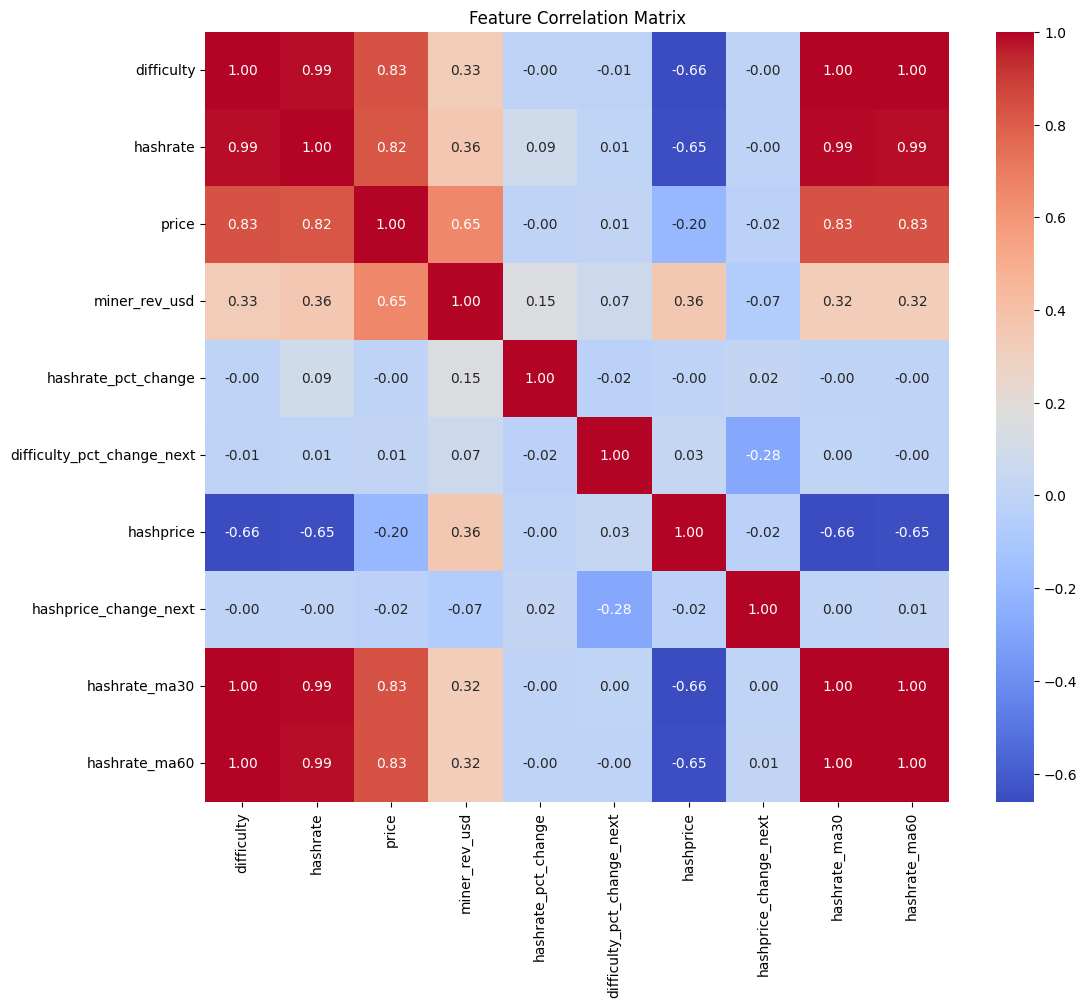

In [70]:
# correlation matrix to see feature relationships using mathplotlib
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

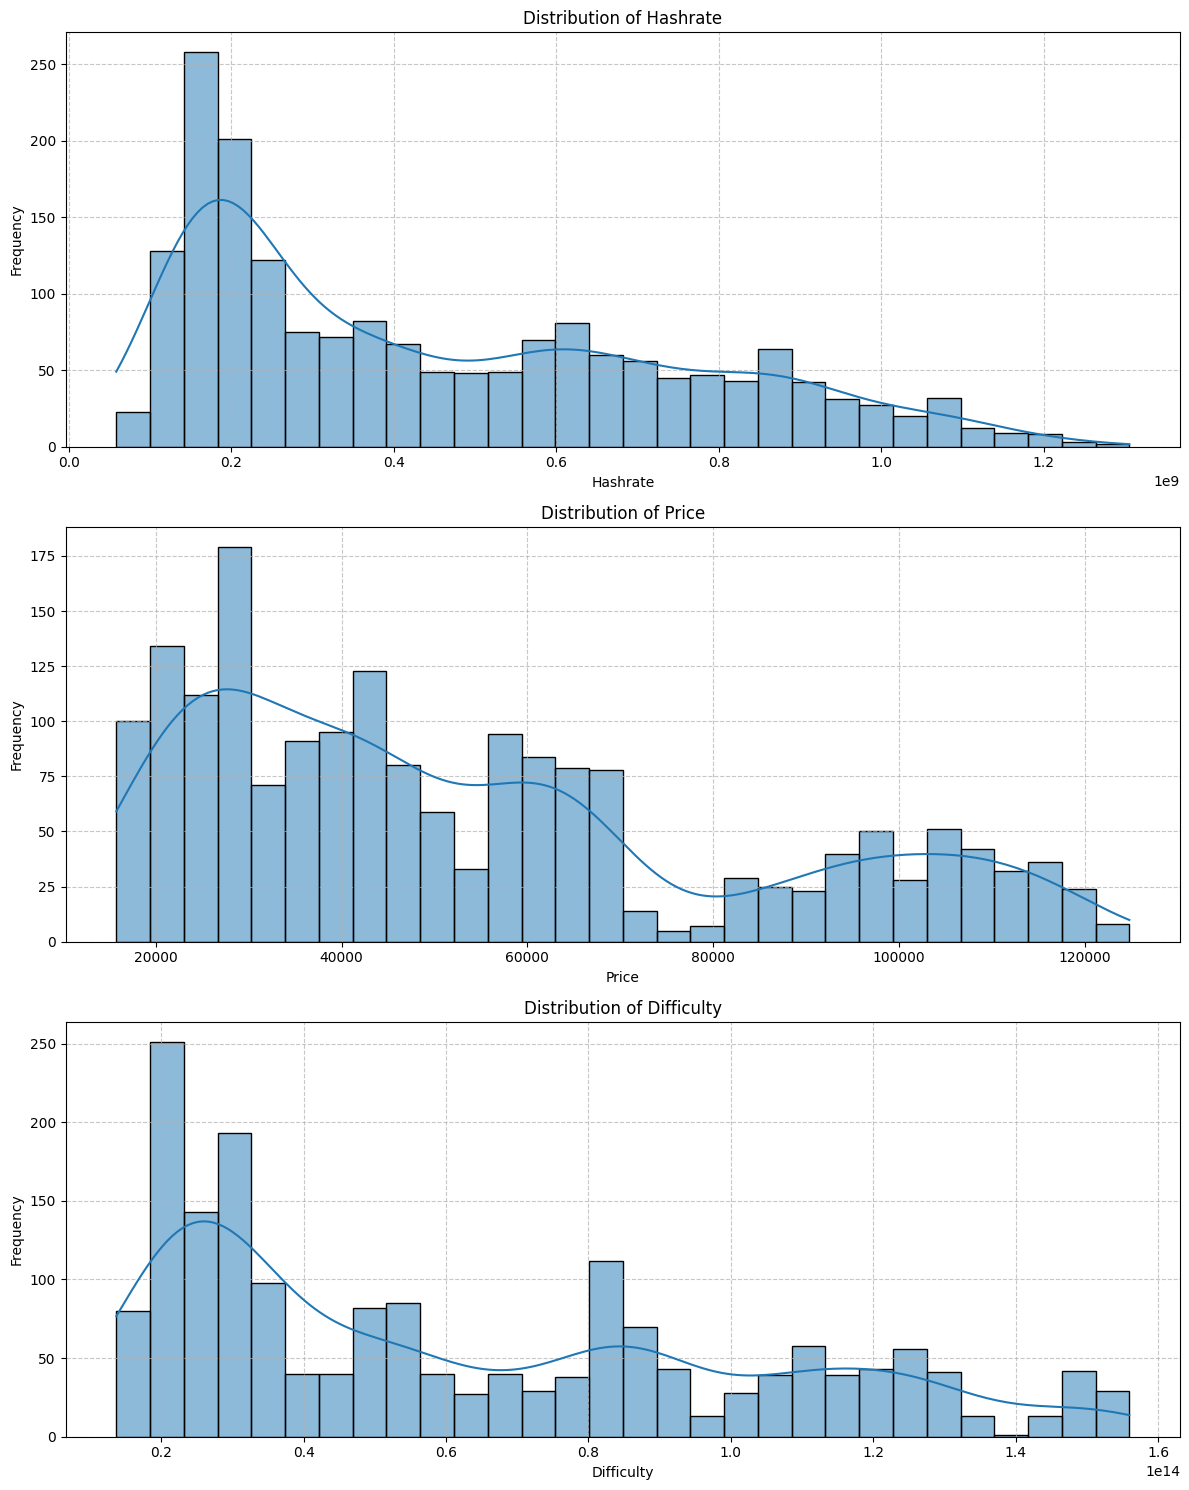

In [71]:
# only include hashrate, price, and difficulty 
num_cols = ['hashrate', 'price', 'difficulty']

# Create a figure and a set of subplots, one for each numerical column
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 5 * len(num_cols)))

# Ensure axes is an array even if there's only one subplot
if len(num_cols) == 1:
    axes = [axes]

# Plot histogram for each numerical column
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

# Feature Engineering

In [72]:
# 1. Lagged features (what happened recently matters)
df['hashrate_lag1'] = df['hashrate'].shift(1)
df['hashrate_lag7'] = df['hashrate'].shift(7)

# Price percentage change
df['price_pct_change'] = df['price'].pct_change() * 100

# 2. Percentage changes (momentum indicators)
df['hashprice_pct_change'] = df['hashprice'].pct_change() * 100

df['hashrate_volatility_7d'] = df['hashrate_pct_change'].rolling(7).std()

# 5. Distance from moving averages (divergence indicator)
df['hashrate_distance_from_ma30'] = ((df['hashrate'] - df['hashrate_ma30']) / df['hashrate_ma30']) * 100
df['hashrate_distance_from_ma60'] = ((df['hashrate'] - df['hashrate_ma60']) / df['hashrate_ma60']) * 100

# 6. Cumulative metrics (how long has stress lasted?)
df['days_below_ma60'] = (df['hashrate'] < df['hashrate_ma60']).astype(int).rolling(30).sum()
df['consecutive_decline_days'] = (df['hashrate_pct_change'] < 0).astype(int)
df['consecutive_decline_days'] = df['consecutive_decline_days'].groupby((df['consecutive_decline_days'] != df['consecutive_decline_days'].shift()).cumsum()).cumsum()

# 8. Flag for hash ribbons
df['hash_ribbon'] = (df['hashrate_ma30'] < df['hashrate_ma60']).astype(int) # hash ribbons, if 30ma < 60ma, then 1 else 0

# Target: predict capitulation 3 days ahead using hash_ribbon
df['target'] = df['hash_ribbon'].shift(-7)

df = df.dropna()  # drop rows with NaN values created by feature engineering

# EDA Pt 2: New Features

In [ ]:
# look at what is happening to price and hashprice during capitulation periods, on the day it first happens (when days_below_ma60 = 0 but hashribbon = 1), then during the period (span of days_below_ma60 > 0)


# Model Building

In [73]:
feature_cols = [
    # Core Hash Ribbons components
    'hashrate_ma30', 'hashrate_ma60',
    'hashrate_distance_from_ma30', 'hashrate_distance_from_ma60',
    
    # Recent changes (momentum)
    'hashrate_pct_change', 'hashprice_pct_change',
    
    # Stress indicators
    'days_below_ma60', 'consecutive_decline_days',
    
    # Volatility
    'hashrate_volatility_7d',
    
    # Lags
    'hashrate_lag1', 'hashrate_lag7'
]

X = df[feature_cols].values
y = df['target'].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features: {len(feature_cols)}")
print(f"Target distribution: Capitulation={y.sum()}, Recovery={len(y)-y.sum()}")

Features: 11
Target distribution: Capitulation=348.0, Recovery=1412.0


In [74]:
class CapitulationDataset(Dataset):
    def __init__(self, X, y, sequence_length=45):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.X) - self.sequence_length
    
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx+self.sequence_length]
        y_label = self.y[idx+self.sequence_length]
        return torch.FloatTensor(X_seq), torch.FloatTensor([y_label])

In [75]:
sequence_length = 45
dataset = CapitulationDataset(X_scaled, y, sequence_length)

# Split
split = int(len(dataset) * 0.8)
train_indices = list(range(split))
test_indices = list(range(split, len(dataset)))


# Weighted sampler for train set (oversample minority class)
# Get labels for training set
train_labels = []
for idx in train_indices:
    _, label = dataset[idx]
    train_labels.append(label.item())

train_labels = np.array(train_labels)

# Calculate sample weights (inverse frequency)
class_counts = np.bincount(train_labels.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels.astype(int)]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Use sampler for training (this will oversample minority class)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"\nTrain: {len(train_dataset)}, Test: {len(test_dataset)}")


Train: 1372, Test: 343


In [76]:
class CapitulationGRU(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout=0.3):
        super(CapitulationGRU, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]
        out = self.dropout(last_output)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CapitulationGRU(input_size=len(feature_cols), hidden_size=32, dropout=0.3)
model = model.to(device)

In [77]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=0.8, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [78]:
num_epochs = 150
train_losses = []
val_losses = []
best_f1 = 0
patience = 30
patience_counter = 0

print("\nTraining...")
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_loss = 0
    val_preds = []
    val_actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            # Collect predictions for F1 calculation
            preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
            val_preds.extend(preds)
            val_actuals.extend(y_batch.cpu().numpy().flatten().astype(int))
    
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    
    # Calculate F1 score
    from sklearn.metrics import f1_score
    val_f1 = f1_score(val_actuals, val_preds, zero_division=0)
    
    # Early stopping based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_f1.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1:.4f}")

# Load best model
model.load_state_dict(torch.load('best_model_f1.pth'))
print(f"\n Training complete! Best F1: {best_f1:.4f}")


Training...
Epoch 10 - Train Loss: 0.0198, Val Loss: 0.1380, Val F1: 0.4156
Epoch 20 - Train Loss: 0.0122, Val Loss: 0.2276, Val F1: 0.2817
Epoch 30 - Train Loss: 0.0157, Val Loss: 0.3347, Val F1: 0.0000
Early stopping at epoch 35

 Training complete! Best F1: 0.5618


In [79]:
model.eval()
probs = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs.extend(outputs.cpu().numpy().flatten())
        actuals.extend(y_batch.numpy().flatten())

probs = np.array(probs)
actuals = np.array(actuals)

precisions, recalls, thresholds = precision_recall_curve(actuals, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\nOptimal threshold for F1: {optimal_threshold:.3f}")

# Predictions with optimal threshold
predictions = (probs > optimal_threshold).astype(int)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(actuals, predictions):.4f}")
print(f"Precision: {precision_score(actuals, predictions, zero_division=0):.4f}")
print(f"Recall: {recall_score(actuals, predictions, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(actuals, predictions, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(actuals, probs):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(actuals, predictions)
print(cm)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

print("\nClass distribution in predictions:")
print(f"Predicted Capitulation: {predictions.sum()} ({predictions.sum()/len(predictions)*100:.1f}%)")
print(f"Predicted Recovery: {len(predictions)-predictions.sum()} ({(len(predictions)-predictions.sum())/len(predictions)*100:.1f}%)")



Optimal threshold for F1: 0.425

FINAL MODEL PERFORMANCE
Accuracy: 0.8921
Precision: 0.7609
Recall: 0.5738
F1-Score: 0.6542
ROC-AUC: 0.9020

Confusion Matrix:
[[271  11]
 [ 26  35]]
TN: 271, FP: 11
FN: 26, TP: 35

Class distribution in predictions:
Predicted Capitulation: 46 (13.4%)
Predicted Recovery: 297 (86.6%)
